<span style="font-size: 14pt">ФИВТ, АПТ, Курс по машинному обучению, Весна 2018, семинар 1</span>

<span style="color:blue; font-size: 12pt">Alexey Romanenko, </span>
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<span style="color:black; font-size: 14pt">Plan</span>
* Метрические алгоритмы
    - kNN
    - Примеры метрик
    - Online Contest: подбор метрик для MNIST
* Визуализация данных в Python
    - Границы для kNN
    - kNN для гауссовских распределений 
    - 
* Cross validation
    - q-Fold
    - Примеры разбиения выборки в Python
    - разбиение выборки на train, validate и test

<span style="color:black; font-size: 14pt">Key words</span>
   * метрические алгоритмы, kNN, weighted kNN
   * проклятие размерности
   * кросс-валидация: назначение (переобучение) и различные варианты кросс-валидации

### Imports

In [68]:
from collections import Counter, defaultdict
from copy import deepcopy
from operator import itemgetter
from random import shuffle
from tqdm import tqdm

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pylab, gridspec, pyplot as plt
from IPython.display import Image

from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.neighbors.base import _get_weights
%matplotlib inline

<h1 align="center"> Метрические алгоритмы </h1>

## Data: Kaggle Digit Recognizer 

Link: http://www.kaggle.com/c/digit-recognizer 
Description: Classify handwritten digits using the famous MNIST data Advanced Reading: http://yann.lecun.com/exdb/mnist/index.html

In [31]:
path = 'C:/Users/rusrom.EUROPE/OneDrive/Teaching/MachineLearning/data' # путь к папке с данными
mnist = pd.read_csv(path+'/digit_recognizer/train.csv')

In [34]:
indices = np.random.permutation(train.shape[0])

mnist_train = mnist.iloc[indices[:15000]]
Y_train = mnist_train['label'].values
X_train = mnist_train[mnist_train.columns[1:]].values

mnist_test = mnist.iloc[indices[15000:20000]]
Y_test = mnist_test['label'].values
X_test = mnist_test[mnist_test.columns[1:]].values

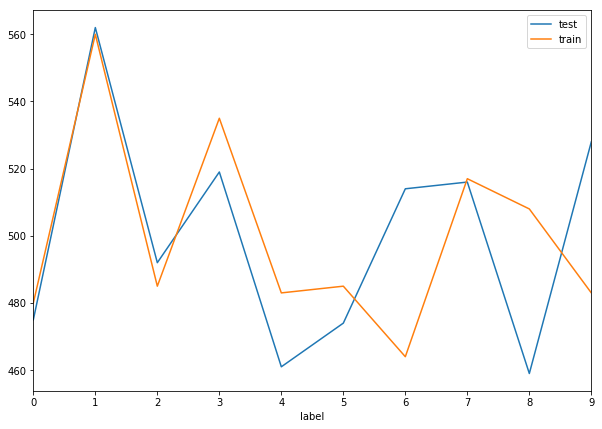

In [36]:
pd.DataFrame({
    'train' : subtrain.groupby('label')['label'].count(),
    'test' : subtest.groupby('label')['label'].count(),
}).plot(figsize = (10,7))

Нарисуем цифры из датасета

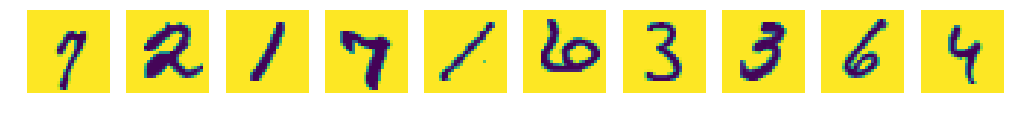

In [37]:
def plot_image(image_id, dataset=X_train, im_size=28):
    pylab.imshow(255-dataset[image_id,:].reshape(im_size, im_size))
    
def plot_grid(image_ids, nrows, ncols, dataset=X_train, im_size=28):
    fig = pyplot.gcf()
    fig.set_size_inches(17.5,15.5)
    for pylab_index, example_id in enumerate(image_ids):
        pylab.subplot(nrows, ncols, pylab_index + 1)
        plot_image(example_id, dataset, im_size)
        pylab.axis('off')
plot_grid(range(10), nrows=1, ncols=10)

# K near neighbours (kNN )

Одна из самых простых идей -- взять класс наиболее близких (похожих объектов) к объекту $u$.

<img src='img/knn-concept.png'>

# K Nearest Neighbors

Выразим эту идею в виде формулы.

## $$a(u, X^l) = \arg \max_{y \in Y} \sum_{i=1}^{l} [y^{(i)} = y]$$
### $(x^{(i)}, y^{(i)})$ - $i$-й сосед объекта $u$ относительно некоторой метрики

In [42]:
def get_neighbors(example_img, X_minus_example, Y_minus_example, estimator):
    distances, indices = estimator.kneighbors(example_img, n_neighbors=10)
    distances, indices = distances[0], indices[0]
    
    df = pd.DataFrame()
    df['distances'], df['indices']  = distances, indices
    df['labels'] = Y_minus_example[indices]
    
    return df

Выберем случайный не очень хороший объект, и посмотрим на 5 ближайших соседей

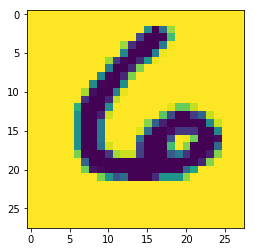

In [40]:
example_id = 400
plot_image(example_id)

In [46]:
estimator = KNeighborsClassifier().fit(X_train, Y_train)
get_neighbors(X_train[example_id], X_train, Y_train, estimator)

C:\Users\rusrom.EUROPE\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


,distances,indices,labels
0,0.000000,400,6
1,1154.845011,12927,6
2,1346.257033,1786,6
3,1362.716405,3188,6
4,1366.622845,4933,6
5,1398.600729,11459,6
6,1420.316866,6792,6
7,1429.433104,7958,6
8,1444.551141,6486,6
9,1485.931021,9180,6


Как предсказать вероятности классов при условии объекта?

In [26]:
prediction = estimator.predict_proba(X_train[example_id])
print ', '.join('y=%s: %.2f' % e for e in enumerate(prediction[0]) if e[1] != 0)

y=2: 1.00


## Отступ, эталонные объекты

Рассмотрим классификатор: 
## $$a: X \rightarrow Y $$

## $$ a(x) = {\mathrm{argmax}} (\Gamma_y(x)), y \in Y, x \in X $$

** Как найти выбросы в обучающей выборке? **

Отступ: 
## $$ M(x_i) = \Gamma_{y_i}(x_i) - \max_{y \in Y \setminus y_i} \Gamma_{y}(x_i) $$
<img src="img/Margin.png">

In [49]:
# Caution: takes 2 minutes
neighbors_for_test = estimator.kneighbors(X_test, 10, return_distance=False)

In [50]:
counts = [np.bincount(x, minlength=10) for x in Y_train[neighbors_for_test]]

In [52]:
ideals = []
noise = []
for i, bincount in enumerate(counts):
    if bincount[Y_test[i]] == 0:
        noise.append(i)
    elif bincount[Y_test[i]] == 10:
        ideals.append(i)
        
print( len(ideals), len(noise))

3677 37


** Noise: **

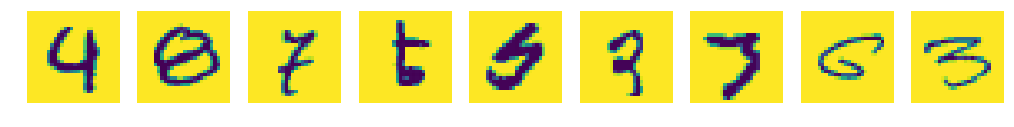

In [53]:
plot_grid(noise[9:18], 1, 9, dataset=X_test, im_size=28)

### Etalones:

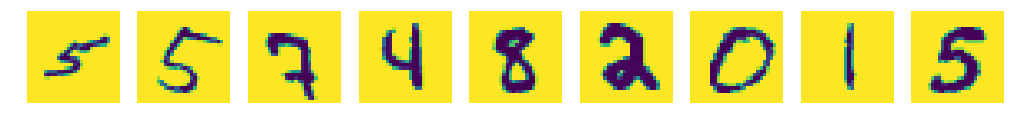

In [54]:
plot_grid(ideals[:9], 1, 9, dataset=X_test, im_size=28)

# Custom Metrics

** Questions **
* Почему Евклидова метрика не всегда подходит?
  - Простым примером является классификация пола человека по зарплате и росту --- зарплата измеряется в тысячах рублей а рост в метрах, но при использовании эвклидовой метрики разница в 1 рубль в зарплате будет эквивалентна разнице в 1 метр в росте человека. Тогда расстояние между людьми будет определяться исключительно зарплатой, а пост будет играть роль только при условии равны зарплат.

* Какие вы знаете другие метрики (расстояния)?
 - Минковского
     - Хемминга
     - Чебышева
 - Косинусная
 - Джаккарда
 - Махалонобиса
 - Левенштейна

In [55]:
from scipy.spatial.distance import cosine, euclidean, minkowski
x_exampe = X_test[10]

## Minkowski Distance

### $$p(x, x_i) = \left(\sum_{j} w_j \cdot |f_j(x) - f_j(x_i)| ^p \right) ^ {\frac{1}{p}}$$

### $w_i$ - веса признаков (нормировка),$~f_j$ - возможно, нелинейное преобразование

<img src='img/1.png'>
<img src='img/3.png'>
<img src='img/2.png'>

Дисперсии весов уменьшаются с ростом p, даже при p=2 веса распределены нормально.

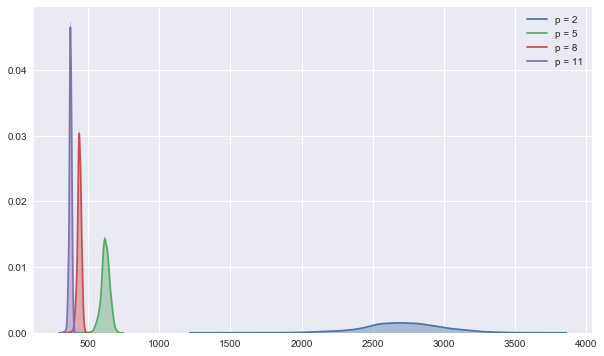

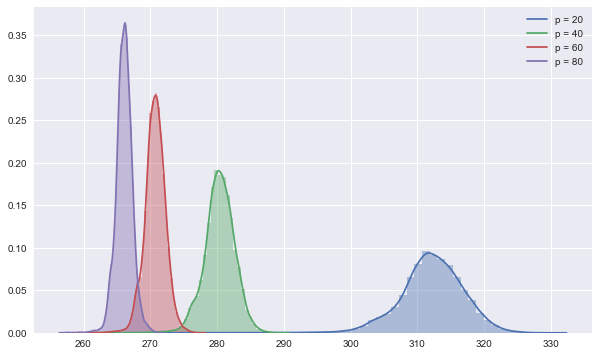

In [60]:
plt.figure(figsize=(10, 6))
for p in range(2, 12, 3):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

plt.figure(figsize=(10, 6))
for p in range(20, 100, 20):
    eucld_dists = [minkowski(x, x_exampe, p) for x in X_train]
    sns.distplot(eucld_dists, kde_kws={'label': 'p = %s' % p})
pylab.show()

Можно сделать вывод, что дисперсия растояния между объектами уменьшается с ростом степени метрики --- все растояния примерно равны.

## Cosine Distance

## $$\text{similarity} = \cos(\theta) = {A \cdot B \over \|A\| \|B\|} = \frac{ \sum\limits_{i=1}^{n}{A_i \times B_i} }{ \sqrt{\sum\limits_{i=1}^{n}{(A_i)^2}} \times \sqrt{\sum\limits_{i=1}^{n}{(B_i)^2}} }$$

<img src = 'https://comsysto.files.wordpress.com/2013/02/euclidean_pearson_similarity.png'>

Расстояния посчитаные с помошью косинусной меры имеют большую дисперсию -- веса соседей отличаются сильнее.

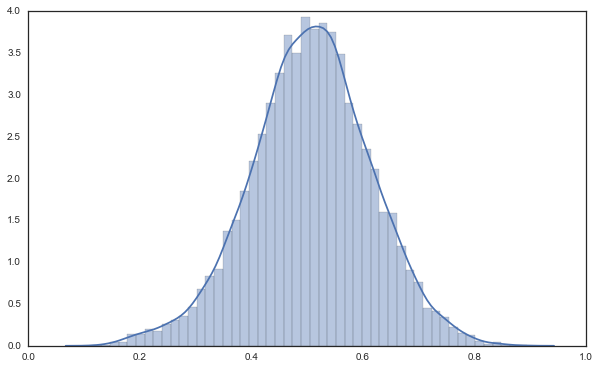

In [39]:
plt.figure(figsize=(10, 6))
cosin_dists = [cosine(x, x_exampe) for x in X_train]
sns.distplot(cosin_dists)

# Spaces, Dimension

------
Задачки

1. Рассмотрим единичный куб и куб с ребром длиной $ e, (e \leq 1) $ в пространстве размерности <b>D</b>. Каким должен быть $e$, чтобы малый куб занимал 1% от объема единичного куба? Рассмотрите случай, когда <b>D</b> равно 2, 10, 100.

2. Рассмотрим сферу радиуса r в пространстве размерности <b>D</b>. Какая часть объема находится между радиусоми r = 1 и $\hat r = 1-\epsilon$.

<img src="1.png" height="450" width="450">

- Качество метрического классификатора полностью определяется метрикой или пространством в котором находятся наши объекты. Неудачный выбор метрики или пространства приведет к низкому качеству классификации.
- Можно проецировать объекты из многомерного пространства на пространство меньшей размерности. К примеру для визуализации на двухмерное пространство.

!!! Исключительно с целью демонстрации бесстильности KNN перед плохим пространством 

Спроецируем объекты на двухмерное подпространство линейно и с сохранение специфичного расстояния.

## Jaccard Index (метрика Джаккарда)

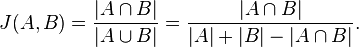

In [11]:
Image(url='https://upload.wikimedia.org/math/0/a/0/0a0633ce67c9130d890078a8d67f0474.png', embed=True)

In [12]:
Image(url='https://upload.wikimedia.org/math/a/2/8/a28e1c667f0354898727933aa746179e.png', embed=True)

## Cosine Distance

### k Nearest Neighbors, kNN $$ a(u; X^l, k) = \arg\max\limits_{y \in Y}\sum\limits_{i= 1}^{k} [y_u^{(i)} = y] $$

Вопрос: Какие проблемы могут возникнуть при классификации нового объекта?

### k weighted Nearest Neighbors $$ a(u; X^l, k) = \arg\max\limits_{y \in Y}\sum\limits_{i= 1}^{k} [y_u^{(i)} = y] w_i $$

In [2]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import KFold, StratifiedKFold, ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [11]:
cv_strategy = ShuffleSplit(X_train.shape[0], n_iter=5, test_size=0.1, random_state=33)

In [12]:
estimators = [
    KNeighborsClassifier(),
    KNeighborsClassifier(algorithm='ball_tree'),
    KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance'),
    KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance', p=1),
    KNeighborsClassifier(algorithm='ball_tree', n_neighbors=3, weights='distance', p=3),    
]
for estimator in estimators:
    scoring = cross_val_score(estimator, X_train, Y_train, scoring='accuracy')
    # print estimator.get_params()
    print('%.3lf' % scoring.mean(), '%.4lf' % scoring.std())

('0.923', '0.0043')
('0.923', '0.0043')
('0.932', '0.0046')
('0.922', '0.0045')
('0.938', '0.0051')


In [13]:
param_grid = {
    'n_neighbors' : [3,5],
    'weights' : ['distance', 'uniform'],
}
grid_cv = GridSearchCV(KNeighborsClassifier(algorithm='ball_tree'), param_grid, scoring='accuracy', cv=cv_strategy)
%time grid_cv.fit(X_train, Y_train)

Wall time: 48.8 s


GridSearchCV(cv=ShuffleSplit(5000, n_iter=5, test_size=0.1, random_state=33),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [3, 5], 'weights': ['distance', 'uniform']},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [18]:
print grid_cv.best_estimator_.get_params()
print grid_cv.best_score_
print grid_cv.best_params_
pd.DataFrame.from_records([
    [repr(params), score, scores.std()]
    for params, score, scores
    in grid_cv.grid_scores_
], columns=['kNN Parameters', 'Accuracy', 'STD']).sort('Accuracy', ascending=False)

{'n_neighbors': 3, 'algorithm': 'ball_tree', 'metric': 'minkowski', 'metric_params': None, 'p': 2, 'weights': 'distance', 'leaf_size': 30}
0.932
{'n_neighbors': 3, 'weights': 'distance'}


,kNN Parameters,Accuracy,STD
0,"{'n_neighbors': 3, 'weights': 'distance'}",0.9320,0.005367
2,"{'n_neighbors': 5, 'weights': 'distance'}",0.9308,0.007547
1,"{'n_neighbors': 3, 'weights': 'uniform'}",0.9284,0.007940
3,"{'n_neighbors': 5, 'weights': 'uniform'}",0.9244,0.009583


#### Customize metric for kNN

In [10]:
from sklearn.metrics.pairwise import distance
from sklearn.neighbors import DistanceMetric
# distance_func = DistanceMetric.get_metric('euclidean')

def my_euclidean(x, y):
    return np.sqrt(np.sum( (x - y) ** 2))

In [19]:
cv_strategy = ShuffleSplit(X_train.shape[0], n_iter=2, test_size=0.1, random_state=33) 
# estimator = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric=distance.cosine) # 0.917-0.92 (2it), 48 sec/iteration
# estimator = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric='cosine') # the same, 1.3 sec/iteration
estimator = KNeighborsClassifier(algorithm='brute', n_neighbors=3, metric=my_euclidean)
%time scoring = cross_val_score(estimator, X_train, Y_train, scoring='accuracy', cv=cv_strategy)
print scoring.mean(), scoring.std()

Wall time: 34.4 s
0.934 0.006


In [57]:
# out of the box Unsupervised Learning
estimator = NearestNeighbors()
estimator.fit(X_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_neighbors=5, p=2, radius=1.0)

#### An Outlier (example) 

In [16]:
def plot_image(image_id, X_train=X_train, size=28):
    pylab.imshow(X_train[image_id].reshape(size, size))
    
def train_set_one_out(example_id, X_train=X_train, Y_train=Y_train):
    X_minus_example = np.r_[X_train[:example_id], X_train[example_id + 1:]]
    Y_minus_example = np.r_[Y_train[:example_id], Y_train[example_id + 1:]]
    return X_minus_example, Y_minus_example

def knn_one_out(example_id, X_train=X_train, Y_train=Y_train, **kwargs):
    X, Y = train_set_one_out(example_id, X_train, Y_train)
    estimator = KNeighborsClassifier(**kwargs).fit(X, Y)
    return estimator

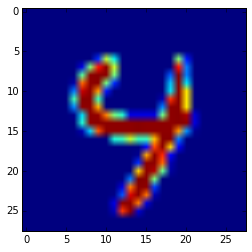

In [80]:
# Here should be example_id with neighbors from different classes!
example_id = 3807
plot_image(example_id)

In [24]:
Y_minus_example = train_set_one_out(example_id)[1]
estimator = knn_one_out(example_id)
distances, indices = estimator.kneighbors(X_train[example_id])
print distances
print indices
print Y_minus_example[indices[0]]

[[ 1867.32321787  1907.30909923  1919.92343597  1945.82990007
   1946.49736707]]
[[4572 4538 4490 2983 4246]]
[2 2 2 2 2]


In [25]:
pd.DataFrame({
    "distances": distances[0],
    "uniform_weights": 1.0,
    "indices": indices[0],
    "labels": Y_minus_example[indices[0]],
}, columns=['distances', 'indices', 'labels', 'uniform_weights'])

,distances,indices,labels,uniform_weights
0,1867.323218,4572,2,1
1,1907.309099,4538,2,1
2,1919.923436,4490,2,1
3,1945.829900,2983,2,1
4,1946.497367,4246,2,1


In [26]:
do_not_show = knn_one_out(example_id).predict_proba(X_train[example_id])
print do_not_show

[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


In [27]:
pd.DataFrame({
    "distances": distances[0],
    "distance_weights": 1.0 / distances[0],
    "normalized_weights": 1.0 / distances[0] / sum(1.0 / distances[0]),
    "indices": indices[0],
    "labels": Y_minus_example[indices[0]],
}, columns=['distances', 'indices', 'labels', 'distance_weights', 'normalized_weights'])

,distances,indices,labels,distance_weights,normalized_weights
0,1867.323218,4572,2,0.000536,0.205313
1,1907.309099,4538,2,0.000524,0.201009
2,1919.923436,4490,2,0.000521,0.199688
3,1945.829900,2983,2,0.000514,0.197029
4,1946.497367,4246,2,0.000514,0.196962


In [28]:
weights = _get_weights(distances, 'distance')
show_flag = True
if show_flag:
    print weights
    print weights / weights.sum()
    print knn_one_out(example_id, weights='distance').predict_proba(X_train[example_id])

[[ 0.00053553  0.0005243   0.00052085  0.00051392  0.00051374]]
[[ 0.20531279  0.2010085   0.19968783  0.19702922  0.19696166]]
[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]]


In [29]:
denominator = sum(1.0 / (1.0 + np.arange(5)))
pd.DataFrame({
    "distances": 1.0 / (1.0 + np.arange(5)),
    "w_distances": 1.0 / (1.0 + np.arange(5)) / denominator,
    "indices": indices[0],
    "labels": Y_minus_example[indices[0]],
}, columns=['distances', 'indices', 'labels', 'w_distances'])

,distances,indices,labels,w_distances
0,1.000000,4572,2,0.437956
1,0.500000,4538,2,0.218978
2,0.333333,4490,2,0.145985
3,0.250000,2983,2,0.109489
4,0.200000,4246,2,0.087591


#### Most Similar Items

In [19]:
estimator = NearestNeighbors()
estimator.fit(X_train)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

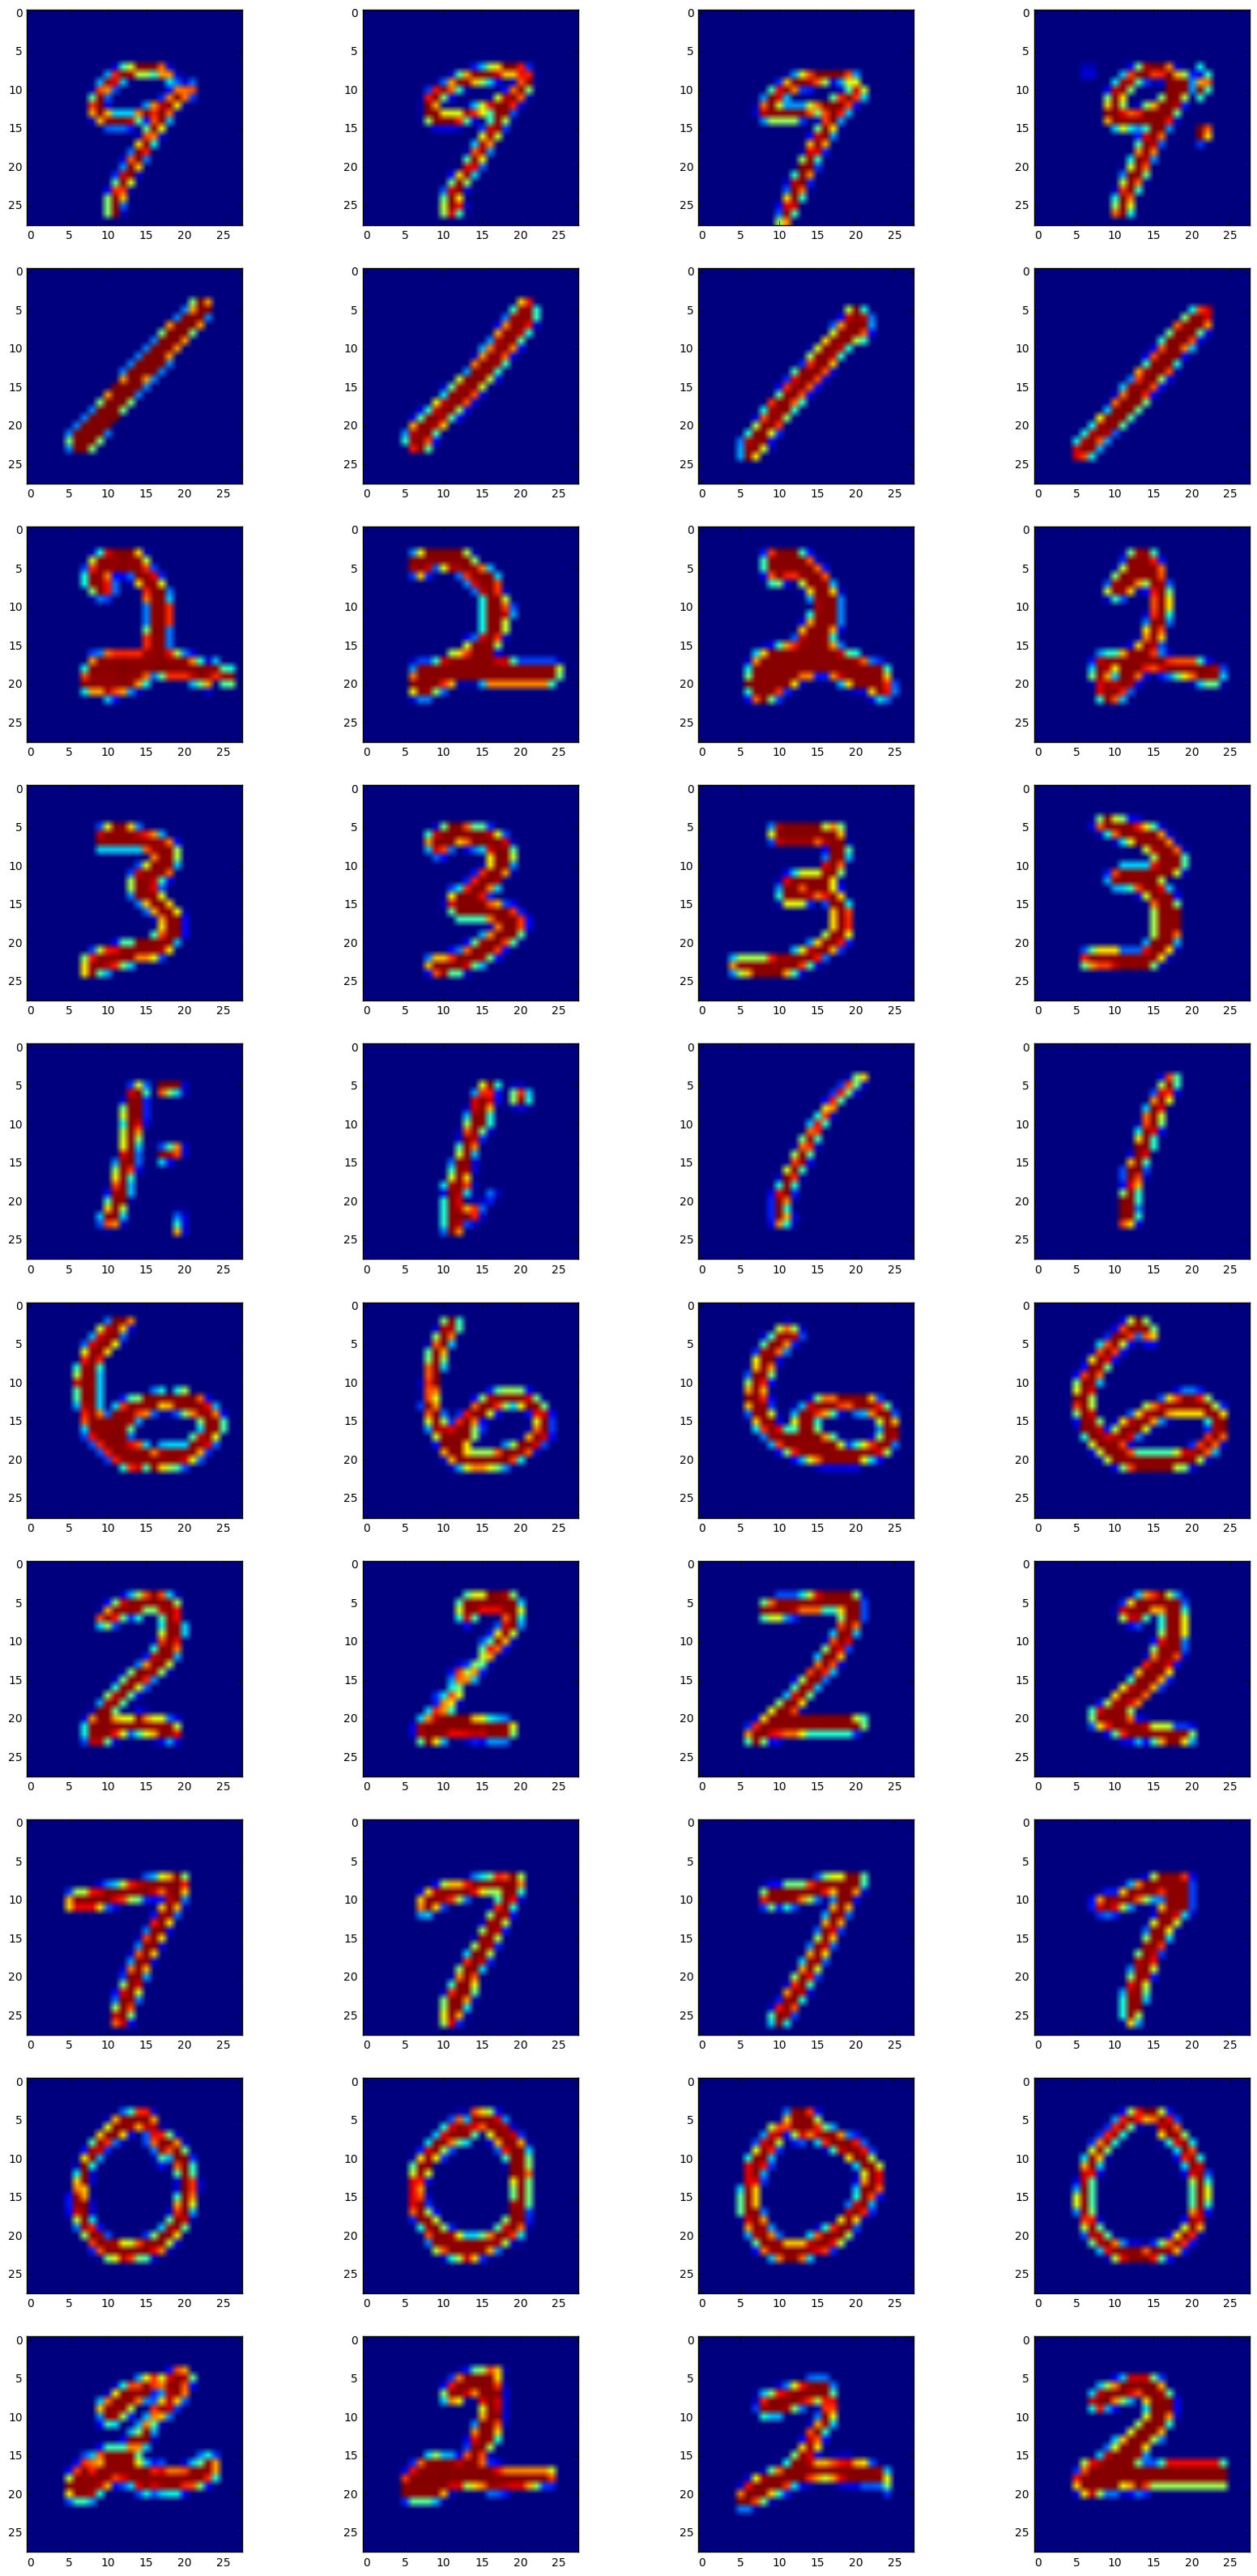

In [23]:
example_ids = [
    3023, 323, 945, 3807, 1415,
    2664, 647, 3453, 1856, 2285
]
fig = pyplot.gcf()
fig.set_size_inches(20.5,40.5)
for pylab_index, example_id in enumerate(example_ids):
    pylab.subplot(len(example_ids), 4, pylab_index * 4 + 1)
    pylab.imshow(X_train[example_id,:].reshape(28,28)) #, cmap='hot'
    distances, indices = estimator.kneighbors([X_train[example_id]])
    indices = indices[0]
    for neighbor_index, neighbor in enumerate(X_train[indices[1:4]]):
        pylab.subplot(len(example_ids), 4, pylab_index * 4 + 1 + neighbor_index + 1)
        pylab.imshow(neighbor.reshape(28,28))

### Margin  $$ a(u) = \arg\max\limits_{y \in Y}\Gamma_{y}(u) $$ $$ M(x_i) = \Gamma_{y_i}(x_i) -\max\limits_{y \in Y\y_i} \Gamma_{y_i}(x_i) $$

In [65]:
def calculate_margin(estimator, class_id, example, Y_train=Y_train, debug=False):
    """
    We assume that we have uniform weights. We also assume
    that we fit our estimator on the whole set. It means
    that we already have our example inside estimator. That is
    why, the first nearest neighbor would be example object.
    
    @param estimator: KNeighborsMixin sublcassed object
        should be already fitted.
    @param class_id: example object has class class_id
    @param example: numpy.array feature represenation of
        example (1x784 matrix based on 28x28 reshaping)
    @param Y_train: we should know object class by its index id
    @params debug: do we need to print debug information?
    """
    counts = Counter(Y_train[estimator.kneighbors([example])[1][0][1:]])
    if debug:
        # in production environment we should use logging module!
        print(counts)
    margin = counts[class_id]
    del counts[class_id]
    if counts:
        margin -= max(counts.values())
    margin *= 1.0 / (estimator.n_neighbors - 1)
    return margin

In [77]:
from tqdm import tqdm
def collect_margins(n_neighbors, margin_calculator, X_train=X_train, Y_train=Y_train, debug_example_id = None, **kwargs):
    margins = []
    estimator = NearestNeighbors(n_neighbors=n_neighbors + 1, **kwargs)
    estimator.fit(X_train)
    for example_id, (class_id, example) in tqdm(enumerate(zip(Y_train, X_train)), position=0):
        margin = margin_calculator(estimator, class_id, example, debug=(example_id == debug_example_id))
        margins.append(margin)

    if debug_example_id is not None:
        print(margins[debug_example_id])
    return margins

In [78]:
# takes some times
margins = collect_margins(n_neighbors=5, margin_calculator=calculate_margin, debug_example_id=3807)

3803it [01:11, 53.02it/s]

Counter({2: 5})


15000it [04:44, 52.64it/s]


1.0


('accuracy:', 0.928)
(-1.0, 40)
(-0.8, 16)
(-0.6000000000000001, 74)
(-0.4, 37)
(-0.2, 117)
(0.0, 76)
(0.2, 187)
(0.4, 96)
(0.6000000000000001, 528)
(1.0, 3829)


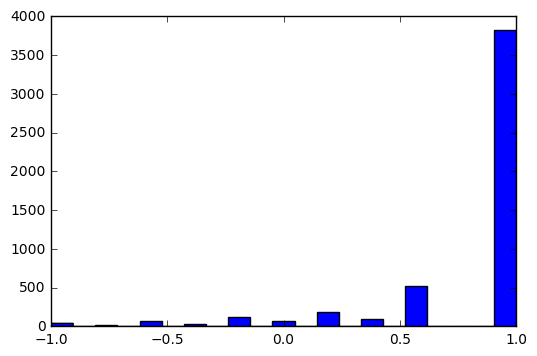

In [29]:
print('accuracy:', 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))
pylab.hist(margins, bins=21)
counts = Counter(margins)
for margin in sorted(counts.keys()):
    print (margin, counts[margin])

(-1.0, 1.0)


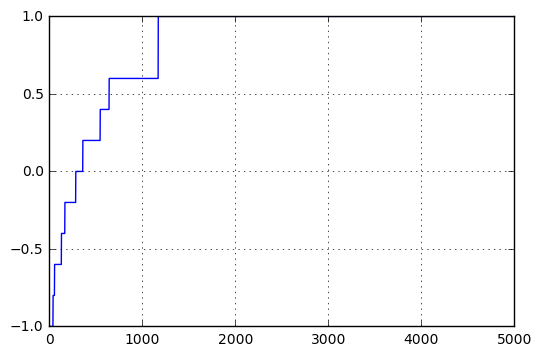

In [30]:
pylab.plot(range(len(margins)), sorted(margins))
pylab.grid()
print (min(margins), max(margins))

### Outlier vs Etalon

In [63]:
def plot_extremes(margins, to_plot_count=4, Y_train=Y_train):
    sorted_margins = sorted((margin, object_id) for object_id, margin in enumerate(margins))
    example_ids = (list(map(itemgetter(0), sorted_margins[:to_plot_count])) + list(map(itemgetter(0), sorted_margins[-to_plot_count:])))
    print (Y_train[example_ids][:to_plot_count])
    print (Y_train[example_ids][to_plot_count:])
    fig = pyplot.gcf()
    fig.set_size_inches(17.5,10.5)
    for pylab_index, example_id in enumerate(example_ids):
        pylab.subplot(2, to_plot_count, pylab_index + 1)
        plot_image(example_id)

In [64]:
plot_extremes(margins, to_plot_count=4)

NameError: name 'margins' is not defined

#### Repeat for the weighted metric

In [37]:
def calculate_weighted_margin(estimator, class_id, example, Y_train=Y_train, debug=False):
    """
    We assume that we have distance weights. We also assume
    that we fit our estimator on the whole set. It means
    that we already have our example inside estimator. That is
    why, the first nearest neighbor would be example object.
    
    @param estimator: KNeighborsMixin sublcassed object
        should be already fitted.
    @param class_id: example object has class class_id
    @param example: numpy.array feature represenation of
        example (1x784 matrix based on 28x28 reshaping)
    @param Y_train: we should know object class by its index id
   
    """
    distances, indices = estimator.kneighbors([example])
    weights = _get_weights(np.asarray([distances[0][1:]]), 'distance')[0]
    if weights.sum()>0:
        weights /= weights.sum()     # деление на ноль
    classes = Y_train[indices[0][1:]]
    
    counts = Counter()
    for class_id_, weight in zip(classes, weights):
        counts[class_id_] += weight
    if debug:
        # in production environment we should use logging module!
        print (counts)
    margin = counts[class_id]
    del counts[class_id]
    if counts:
        margin -= max(counts.values())
    return margin

In [74]:
# est = NearestNeighbors(n_neighbors=5 + 1)
# est.fit(X_train)
# distances, indices = est.kneighbors(X_train[3807])
# weights = _get_weights(np.asarray([distances[0][1:]]), 'distance')[0]
# weights /= weights.sum()
calculate_weighted_margin(estimator = est, class_id=4, example=X_train[3807], Y_train=Y_train, debug=True)

Counter({4: 0.80290485645454235, 9: 0.19709514354545757})


0.60580971290908481

In [75]:
margins = collect_margins(n_neighbors=5, margin_calculator=calculate_weighted_margin, debug_example_id=3807)

Counter({4: 0.80290485645454235, 9: 0.19709514354545757})
0.605809712909


accuracy: 0.9328


(array([  4.90000000e+01,   0.00000000e+00,   1.70000000e+01,
          1.00000000e+00,   7.90000000e+01,   0.00000000e+00,
          4.60000000e+01,   1.00000000e+00,   1.17000000e+02,
          9.00000000e+00,   6.10000000e+01,   6.00000000e+00,
          1.58000000e+02,   3.60000000e+01,   8.80000000e+01,
          1.80000000e+01,   3.53000000e+02,   1.92000000e+02,
          0.00000000e+00,   0.00000000e+00,   3.76900000e+03]),
 array([-1.        , -0.9047619 , -0.80952381, -0.71428571, -0.61904762,
        -0.52380952, -0.42857143, -0.33333333, -0.23809524, -0.14285714,
        -0.04761905,  0.04761905,  0.14285714,  0.23809524,  0.33333333,
         0.42857143,  0.52380952,  0.61904762,  0.71428571,  0.80952381,
         0.9047619 ,  1.        ]),
 <a list of 21 Patch objects>)

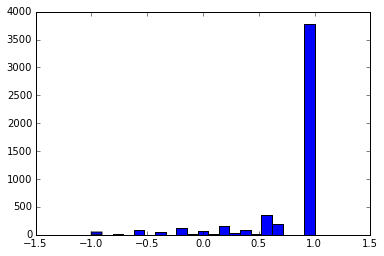

In [76]:
print ('accuracy:', 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))
pylab.hist(margins, bins=21)

-1.0 1.0


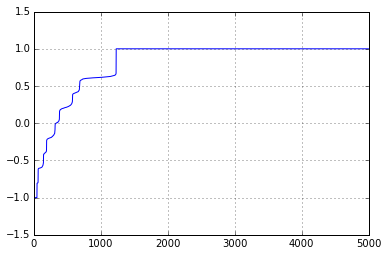

In [77]:
pylab.plot(range(len(margins)), sorted(margins))
pylab.grid()
print (min(margins), max(margins))

C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\rusrom\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


[5 5 5 5]
[7 7 7 7]


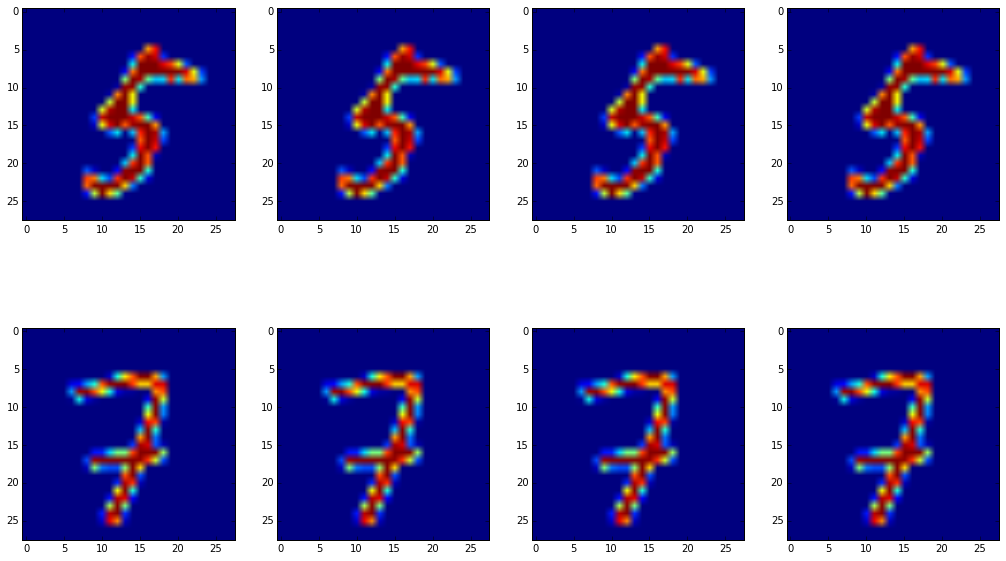

In [84]:
plot_extremes(margins, to_plot_count=4)

### Off-line contest (HW)

In [53]:
def metric_example(x, y):
    return np.sqrt(np.sqrt(np.sum( (x - y) ** 4)))

def my_metric_mink(x, y):
    return (np.sum( abs(x - y) ** 3.5))**(1/3.5)

def metric_cos(x, y):
    return 1 - np.dot(x,y)/(np.sqrt(np.dot(x,x)*np.dot(y,y)))

#from scipy.spatial.distance import mahalanobis

#def metric_mahalanobis(x, y):
#    return mahalanobis(x, y, np.linalg.norm(x - y)) 

In [117]:
metric_mink(X_train[0], X_train[1])
# print(np.sum( (X_train[0] - X_train[1])**4))
# import math
# np.sum(math.pow((X_train[0] - X_train[1])),4)

125578885228.83086

In [114]:
np.sum(abs(X_train[0] - X_train[1])**3.5)

18450750532.317303

In [38]:
# Takes a lot of time!
%time margins = collect_margins(n_neighbors=5, margin_calculator=calculate_weighted_margin, debug_example_id=3807, metric=metric_example)

Counter({3: 0.99999999999999989})
1.0
Wall time: 17min 5s


In [39]:
print ('accuracy:', 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))

('accuracy:', 0.9436)


#### Insert Your Metric

In [54]:
metric_properties = {
#    'euc' : {'metric' : 'euclidean'}, # 1
#     'cheb' : {'metric' : 'chebyshev'}, # 
#     'cosine' : {'metric' : metric_cos}, # 
    'mink3.5' : {'metric' : my_metric_mink}, # 2
#    'mink3' : {'p' : 3},  # 3
#     'mink4' : {'metric': metric_example}, #
}

In [49]:
# metric_margins = {}
for name, metric in metric_properties.items():
    print('processing team %s...' % name)
    %time margins = collect_margins(n_neighbors=5, margin_calculator=calculate_weighted_margin, **metric)
    metric_margins[name] = sorted(margins)

processing team cosine...
Wall time: 2min 32s
processing team mink3.5...
Wall time: 15min 48s


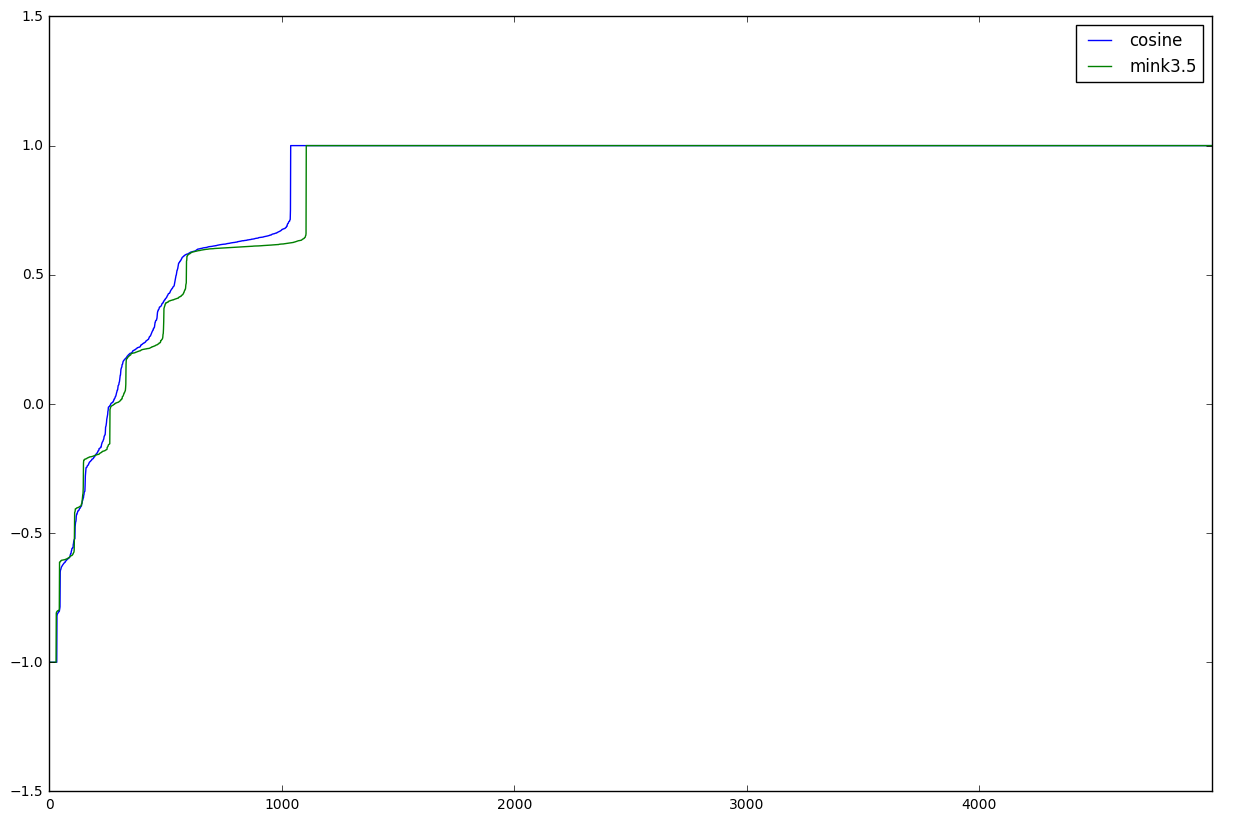

In [51]:
team_df = pd.DataFrame(metric_margins)
team_df.plot(figsize = (15, 10))

In [128]:
pd.DataFrame({
    'accuracy' : team_df.apply(lambda margins: 1.0 * sum(1 for margin in margins if margin > 0.0) / len(margins))
}).sort('accuracy', ascending=False)

,accuracy
cosine,0.9476
euc,0.9328
mink0.25,0.8666


<h1 align="center"> Визуализация </h1>

<h1 align="center"> Кросс-валидация и переобучение </h1>

* intro into cross-validation and bias-variance trade-off
    - sklearn-cross-validation
    - seminar2.pdf
* model assessment
    - reading_data.ipnb
    

# Cross-Validation в sklearn

документация: http://scikit-learn.org/stable/modules/cross_validation.html

In [47]:
from sklearn import model_selection, datasets
import numpy as np

ImportError: cannot import name 'comb'

### Разовое разбиение данных на обучение и тест с помощью train_test_split

In [2]:
iris = datasets.load_iris()

In [3]:
train_data, test_data, train_labels, test_labels = cross_validation.train_test_split(iris.data, iris.target, 
                                                                                     test_size = 0.3)

In [4]:
#убедимся, что тестовая выборка действительно составляет 0.3 от всех данных
float(len(test_labels))/len(iris.data)

0.3

In [5]:
print 'Размер обучающей выборки: {} объектов \nРазмер тестовой выборки: {} объектов'.format(len(train_data),
                                                                                            len(test_data))

Размер обучающей выборки: 105 объектов 
Размер тестовой выборки: 45 объектов


In [6]:
print 'Обучающая выборка:\n', train_data[:5]
print '\n'
print 'Тестовая выборка:\n', test_data[:5]

Обучающая выборка:
[[ 6.9  3.1  5.1  2.3]
 [ 4.9  3.1  1.5  0.1]
 [ 6.4  3.2  5.3  2.3]
 [ 5.7  3.   4.2  1.2]
 [ 4.9  3.1  1.5  0.1]]


Тестовая выборка:
[[ 6.6  3.   4.4  1.4]
 [ 4.6  3.6  1.   0.2]
 [ 5.8  2.7  5.1  1.9]
 [ 5.5  2.4  3.8  1.1]
 [ 6.4  3.1  5.5  1.8]]


In [7]:
print 'Метки классов на обучающей выборке:\n', train_labels
print '\n'
print 'Метки классов на тестовой выборке:\n', test_labels

Метки классов на обучающей выборке:
[2 0 2 1 0 2 0 0 1 0 1 0 1 2 2 0 0 0 2 0 2 2 1 0 0 2 1 1 0 1 2 2 1 0 1 0 0
 1 1 2 2 1 1 0 1 2 0 0 1 0 2 1 0 1 0 2 0 0 0 1 2 2 1 0 0 2 0 2 0 0 0 1 1 2
 0 1 0 1 1 2 2 2 1 0 2 1 1 1 2 1 1 1 2 1 1 2 0 1 0 2 2 0 1 2 1]


Метки классов на тестовой выборке:
[1 0 2 1 2 0 2 2 0 2 1 0 1 2 1 0 2 1 1 2 2 0 2 0 2 2 1 1 0 1 0 2 2 2 2 2 1
 0 2 1 0 0 1 2 0]


### Стратегии проведения кросс-валидации

#### KFold

In [8]:
for train_indices, test_indices in cross_validation.KFold(10, n_folds = 5):
    print train_indices, test_indices

[2 3 4 5 6 7 8 9] [0 1]
[0 1 4 5 6 7 8 9] [2 3]
[0 1 2 3 6 7 8 9] [4 5]
[0 1 2 3 4 5 8 9] [6 7]
[0 1 2 3 4 5 6 7] [8 9]


In [9]:
#многократный запуск приводит к различным разбиениям
for train_indices, test_indices in cross_validation.KFold(10, n_folds = 2, shuffle = True):
    print train_indices, test_indices

[2 3 4 7 9] [0 1 5 6 8]
[0 1 5 6 8] [2 3 4 7 9]


In [10]:
#многократный запуск приводит к одному и  тому же разбиению, результат запуска детерминированный
for train_indices, test_indices in cross_validation.KFold(10, n_folds = 2, shuffle = True, random_state = 1):
    print train_indices, test_indices

[1 3 5 7 8] [0 2 4 6 9]
[0 2 4 6 9] [1 3 5 7 8]


#### StratifiedKFold

In [11]:
target = np.array([0] * 5 + [1] * 5)
print target
for train_indices, test_indices in cross_validation.StratifiedKFold(target, n_folds = 2, shuffle = True, random_state = 0):
    print train_indices, test_indices

[0 0 0 0 0 1 1 1 1 1]
[3 4 8 9] [0 1 2 5 6 7]
[0 1 2 5 6 7] [3 4 8 9]


In [12]:
target = np.array([0, 1] * 5)
print target
for train_indices, test_indices in cross_validation.StratifiedKFold(target, n_folds = 2,shuffle = True):
    print train_indices, test_indices

[0 1 0 1 0 1 0 1 0 1]
[1 2 4 5] [0 3 6 7 8 9]
[0 3 6 7 8 9] [1 2 4 5]


#### ShuffleSplit

In [13]:
for train_indices, test_indices in cross_validation.ShuffleSplit(10, n_iter = 10, test_size = 0.2):
    print train_indices, test_indices

[6 1 0 3 8 5 7 2] [4 9]
[6 4 2 5 3 8 1 9] [0 7]
[8 0 1 9 6 2 3 7] [4 5]
[5 3 0 7 6 8 1 4] [2 9]
[2 6 1 3 4 7 8 0] [9 5]
[2 6 5 7 8 4 9 3] [0 1]
[0 6 7 4 8 2 3 5] [9 1]
[2 9 4 6 3 8 0 7] [1 5]
[3 2 9 1 5 8 0 4] [6 7]
[5 1 9 7 6 4 2 0] [3 8]


#### StratifiedShuffleSplit

In [14]:
target = np.array([0] * 5 + [1] * 5)
print target
for train_indices, test_indices in cross_validation.StratifiedShuffleSplit(target, n_iter = 4, test_size = 0.2):
    print train_indices, test_indices

[0 0 0 0 0 1 1 1 1 1]
[3 7 2 4 5 0 8 9] [6 1]
[1 5 0 9 6 3 4 7] [2 8]
[6 0 7 8 9 3 4 1] [2 5]
[8 3 1 2 5 0 6 7] [4 9]


#### Leave-One-Out

In [15]:
for train_indices, test_index in cross_validation.LeaveOneOut(10):
    print train_indices, test_index

[1 2 3 4 5 6 7 8 9] [0]
[0 2 3 4 5 6 7 8 9] [1]
[0 1 3 4 5 6 7 8 9] [2]
[0 1 2 4 5 6 7 8 9] [3]
[0 1 2 3 5 6 7 8 9] [4]
[0 1 2 3 4 6 7 8 9] [5]
[0 1 2 3 4 5 7 8 9] [6]
[0 1 2 3 4 5 6 8 9] [7]
[0 1 2 3 4 5 6 7 9] [8]
[0 1 2 3 4 5 6 7 8] [9]


Больше стратегий проведения кросс-валидации доступно здесь: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators

<h1 align="center"> Summary </h1>

* Metrics Algorithms
    - the simplest ML algorithms 
    - score depends on the metric and space property.
    - use all data set to classify, need $O(log(n))$ to predict. 
    - there are эталонные, неинформативные, пограничные, ошибки и выбросы
* Cross_validation
    - way to fit ML algorithms

## Обратная связь
  * оцените <a href="https://goo.gl/forms/kYZuyAQLuwo8szce2"> семинар </a>
  * оцените <a href="https://goo.gl/forms/zeZiu1fSgrpPGp6T2"> лекцию </a>